In [6]:
# import autosklearn.classification
from pipeline import *

df_coaches = pd.read_csv('dataset/cleaned/coaches.csv')
# models = [
#     lambda: RandomForestClassifier(n_estimators=100, random_state=42),
#     #lambda: LogisticRegression(max_iter=1000, random_state=42),
#     lambda: SVC(C=1.0, kernel='rbf', probability=True),
#     lambda: GaussianNB(),
#     lambda: KNeighborsClassifier(n_neighbors=5),
#     lambda: DecisionTreeClassifier(max_depth=5, random_state=42),
#     lambda: GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
#     lambda: MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
# ]

# After grid hyperparameter tuning
models = [
    lambda: RandomForestClassifier(n_estimators=100, random_state=42),
    lambda: SVC(C=0.1, kernel='linear', probability=True),
    lambda: GaussianNB(),
    lambda: KNeighborsClassifier(n_neighbors=15, weights='uniform'),
    lambda: DecisionTreeClassifier(max_depth=5, min_samples_split=2, random_state=42),
    lambda: GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42),
    lambda: MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
]

def run_window_decay(model, year):
    l = []


    clf = model()
    decay_rate=0.1
    df_teams_merged = []
    test = []
    train = []
    for i in range(2, year + 1):
        df_teams_merged = pipeline_clf(year=i)
        weight = decay_rate ** (10 - i - 1)

        df_teams_merged['confID'] = df_teams_merged['confID'].replace({'EA': 0, 'WE': 1})

        train = df_teams_merged[df_teams_merged['year'] < i]
        test = df_teams_merged[df_teams_merged['year'] == i]

        #if (year == i):
        #    break


        X_train = train[train.drop(['playoff', 'year', 'tmID'], axis=1).columns]
        y_train = train['playoff']
        sample_weight = [weight] * len(X_train)

        if type(model()).__name__ in ["KNeighborsClassifier", "MLPClassifier"]:
            clf.fit(X_train, y_train)  # This model don't support sample weights
        else:
            clf.fit(X_train, y_train, sample_weight=sample_weight)

    predictions = clf.predict_proba(test.drop(['playoff', 'year', 'tmID'], axis=1))[:, 1]
    test['predictions'] = predictions
    df_teams_merged['predictions'] = 0
    df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions

    df_teams_merged['confID'] = df_teams_merged['confID'].replace({0: 'EA', 1 : 'WE'})

    # print the year and the predicted scores
    # print(df_teams_merged[df_teams_merged['year'] == year][['tmID', 'confID', 'predictions', 'awards', 'offensive_strength']].sort_values(by='predictions', ascending=False))


    df_teams, ea_teams, we_teams = classify_playoff_entry(
            df_teams_merged, year)

    ea_predictions = ea_teams['tmID'].unique()
    we_predictions = we_teams['tmID'].unique()


    accuracy = calculate_playoff_accuracy(
        year, ea_predictions, we_predictions, display_results = False)

    return accuracy


In [ ]:
pipeline_year(11,display_results=True, model=models[4])

In [ ]:
pipeline_year(11,display_results=True, model=models[1])['precision']

In [ ]:
pipeline_year(11,display_results=True, model=models[0])['precision']

/home/sparks/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sparks/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sparks/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sparks/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[[62.5, 50.0, 75.0, 75.0, 75.0, 100.0, 62.5, 87.5, 87.5], [75.0, 50.0, 62.5, 75.0, 87.5, 100.0, 62.5, 75.0, 87.5], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 62.5, 87.5], [62.5, 50.0, 75.0, 62.5, 87.5, 100.0, 62.5, 75.0, 75.0], [62.5, 62.5, 62.5, 62.5, 75.0, 50.0, 62.5, 50.0, 87.5], [50.0, 50.0, 62.5, 75.0, 75.0, 100.0, 62.5, 87.5, 87.5], [50.0, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 62.5, 75.0]]


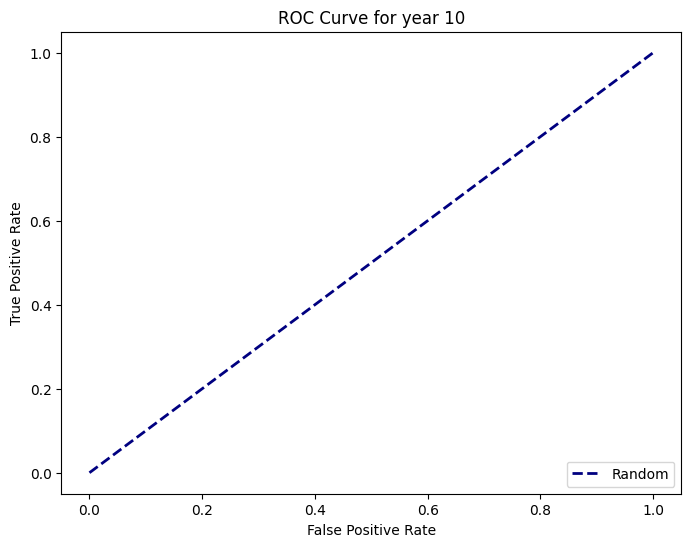

In [8]:
from pipeline import *

def check_accuracy_by_year2(models):
    # Create a list to store accuracy values for each model
    accs = []
    model_accs = []
    roc_curves = []
    model_roc_curve = []
    
    # Define the years
    years = list(range(2, 11))
    
    # Calculate accuracy for each year for each model
    models_grid = [
        lambda: RandomForestClassifier(),
        # LogisticRegression(),
        lambda: SVC(probability=True),
        lambda: GaussianNB(),
        lambda: KNeighborsClassifier(),
        lambda: DecisionTreeClassifier(),
        lambda: GradientBoostingClassifier(),
        lambda: MLPClassifier()
    ]

    param_grids = [
        {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5, 10],
            'random_state': [42]
        },
        {
            'C': [1.0, 0.1, 0.01],
            'kernel': ['rbf', 'linear'],
            'probability': [True]
        },
        {   # GaussianNB
            'var_smoothing': [1e-09, 1e-08, 1e-07]
        },
        {
            'n_neighbors': [5, 10, 15],
            'weights': ['uniform', 'distance']
        },
        {
            'max_depth': [5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'random_state': [42]
        },
        {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.1, 0.01, 0.001],
            'max_depth': [3, 5, 7],
            'random_state': [42]
        },
        {
            'hidden_layer_sizes': [(100, 50), (200, 100), (300, 150)],
            'max_iter': [1000, 2000, 3000],
            'random_state': [42]
        }
    ]
    
    for i, model in enumerate(models):
        # model_accs = [run_window_decay(model, year) for year in years]
        model_accs = [pipeline_year(year, model=model, display_results=False)['precision'] for year in years]
        # model_accs = [pipeline_year_grid_search(year, model=model, parameters=param_grids[i], display_results=False)['precision'] for year in years]
        # model_roc_curve = [pipeline_year(year, model=model, display_results=False)['roc'] for year in years]

        accs.append(model_accs)
        # roc_curves.append(model_roc_curve)
    #accs = [[75.0, 50.0, 75.0, 75.0, 87.5, 87.5, 62.5, 87.5, 87.5], [50.0, 50.0, 87.5, 50.0, 62.5, 25.0, 62.5, 62.5, 75.0], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 75.0, 87.5], [50.0, 50.0, 62.5, 62.5, 62.5, 87.5, 62.5, 62.5, 75.0], [62.5, 50.0, 87.5, 62.5, 75.0, 75.0, 62.5, 50.0, 75.0], [50.0, 50.0, 50.0, 87.5, 75.0, 87.5, 62.5, 62.5, 87.5], [62.5, 50.0, 50.0, 75.0, 75.0, 100.0, 62.5, 87.5, 75.0]]
    print(accs)

    # Plot the accuracy line graphs for each model
    for i, model_acc in enumerate(accs):
        plt.plot(years, model_acc, label=f"{type(models[i]()).__name__ }", marker='o', linestyle='-', alpha=0.5)

    # # Add legend
    plt.legend()

    # Set Y-axis limits
    plt.ylim(0, 100)

    plt.xlabel("Year")
    plt.ylabel("Precision")
    plt.title("Precision by year")
    plt.grid(True)

    plt.show()

    # Plot the ROC line graphs for each model
    # plt.figure(figsize=(8, 6))
    
    # for i, model_roc in enumerate(roc_curves):
    #     for j in range(len(years)):
    #         fpr = model_roc[j][0]
    #         tpr = model_roc[j][1]
    #         plt.plot(fpr, tpr, lw=2, label=f'AUC = {auc(fpr, tpr):.2f} - {type(models[i]()).__name__ }', marker='o', linestyle='-')


    # # Add legend
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC Curve for year 10')  
    # plt.legend(loc='lower right')
    # plt.show()

    # Add labels for each data point
    # for i, model_acc in enumerate(accs):
    #     for j, acc in enumerate(model_acc):
    #         plt.text(years[j], acc, f"{acc:.2f}", ha="center", va="bottom")

    

check_accuracy_by_year2(models)


In [ ]:
run_window_decay(models[0], 10)

[75.0, 75.0, 69.44444444444444, 72.22222222222223, 63.888888888888886, 72.22222222222223, 66.66666666666667]
[14.433756729740644, 14.433756729740644, 11.947673982003648, 14.163943093313291, 10.936122047238628, 16.43355495305449, 11.785113019775793]
75.0
63.888888888888886
10.936122047238628


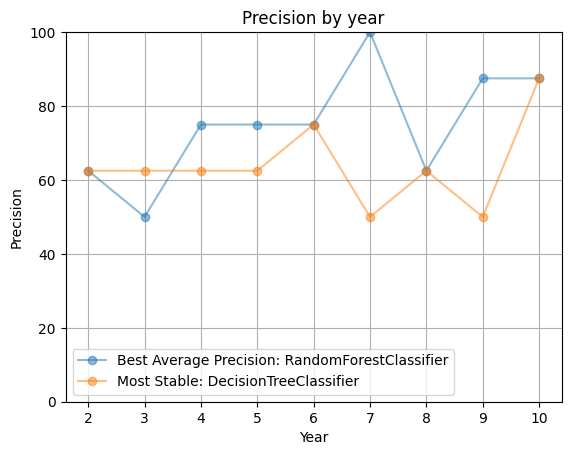

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# accs = [[75.0, 50.0, 75.0, 75.0, 87.5, 87.5, 62.5, 87.5, 87.5], [50.0, 50.0, 87.5, 50.0, 62.5, 25.0, 62.5, 62.5, 75.0], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 75.0, 87.5], [50.0, 50.0, 62.5, 62.5, 62.5, 87.5, 62.5, 62.5, 75.0], [62.5, 50.0, 87.5, 62.5, 75.0, 75.0, 62.5, 50.0, 75.0], [50.0, 50.0, 50.0, 87.5, 75.0, 87.5, 62.5, 62.5, 87.5], [62.5, 50.0, 50.0, 75.0, 75.0, 100.0, 62.5, 87.5, 75.0]]
accs_grid = [[62.5, 50.0, 75.0, 75.0, 75.0, 100.0, 62.5, 87.5, 87.5], [75.0, 50.0, 62.5, 75.0, 87.5, 100.0, 62.5, 75.0, 87.5], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 62.5, 87.5], [62.5, 50.0, 75.0, 62.5, 87.5, 100.0, 62.5, 75.0, 75.0], [62.5, 62.5, 62.5, 62.5, 75.0, 50.0, 62.5, 50.0, 87.5], [50.0, 50.0, 62.5, 75.0, 75.0, 100.0, 62.5, 87.5, 87.5], [50.0, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 62.5, 75.0]]

years = list(range(2, 11))
model_names = [type(model()).__name__ for model in models]

# Calculate the average accuracy and standard deviation for each model
avg_accuracies = [np.mean(model_accs) for model_accs in accs_grid] #accs
std_accuracies = [np.std(model_accs) for model_accs in accs_grid]  #accs

print(avg_accuracies)
print(std_accuracies)

# Find the index of the model with the highest average accuracy and lowest standard deviation
best_avg_model_index = np.argmax(avg_accuracies)
most_stable_model_index = np.argmin(std_accuracies)

# Plot the accuracy line graphs for the best average model and the most stable model
plt.plot(years, accs_grid[best_avg_model_index], label=f"Best Average Precision: {model_names[best_avg_model_index]}", marker='o', linestyle='-', alpha=0.5)
plt.plot(years, accs_grid[most_stable_model_index], label=f"Most Stable: {model_names[most_stable_model_index]}", marker='o', linestyle='-', alpha=0.5)

# Add legend
plt.legend()

# Set Y-axis limits
plt.ylim(0, 100)

plt.xlabel("Year")
plt.ylabel("Precision")
plt.title("Precision by year")
plt.grid(True)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

accs = [[75.0, 50.0, 75.0, 75.0, 87.5, 87.5, 62.5, 87.5, 87.5], [50.0, 50.0, 87.5, 50.0, 62.5, 25.0, 62.5, 62.5, 75.0], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 75.0, 87.5], [50.0, 50.0, 62.5, 62.5, 62.5, 87.5, 62.5, 62.5, 75.0], [62.5, 50.0, 87.5, 62.5, 75.0, 75.0, 62.5, 50.0, 75.0], [50.0, 50.0, 50.0, 87.5, 75.0, 87.5, 62.5, 62.5, 87.5], [62.5, 50.0, 50.0, 75.0, 75.0, 100.0, 62.5, 87.5, 75.0]]
accs_grid = [[62.5, 50.0, 75.0, 75.0, 75.0, 100.0, 62.5, 87.5, 87.5], [75.0, 50.0, 62.5, 75.0, 87.5, 100.0, 62.5, 75.0, 87.5], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 62.5, 87.5], [62.5, 50.0, 75.0, 62.5, 87.5, 100.0, 62.5, 75.0, 75.0], [62.5, 62.5, 62.5, 62.5, 75.0, 50.0, 62.5, 50.0, 87.5], [50.0, 50.0, 62.5, 75.0, 75.0, 100.0, 62.5, 87.5, 87.5], [50.0, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 62.5, 75.0]]

years = list(range(2, 11))
model_names = [type(model()).__name__ for model in models]

# Calculate the average accuracy and standard deviation for each model
avg_accuracies = [np.mean(model_accs) for model_accs in accs]
std_accuracies = [np.std(model_accs) for model_accs in accs]

print(list(zip(model_names, avg_accuracies)))
print(std_accuracies)

# Plot KNN before and after grid search
plt.plot(years, accs[6], label=f"Random Forest before", marker='o', linestyle='-', alpha=0.5)
plt.plot(years, accs_grid[6], label=f"Random Forest after", marker='o', linestyle='-', alpha=0.5)

# Add legend
plt.legend()

# Set Y-axis limits
plt.ylim(0, 100)

plt.xlabel("Year")
plt.ylabel("Precision")
plt.title("Precision by year")
plt.grid(True)

plt.show()